In [1]:
import sys
import os
import math
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from collections import defaultdict
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from datasets.Waymo import WaymoDataset, waymo_collate_fn, get_image_coordinates, get_image_velocity
from model.layers.Spline import NaturalCubicSpline

In [2]:
tfrecord_path = '../../data1/waymo_dataset/uncompressed/tf_example/validation'
idx_path = '../../idx/validation'
dataset = WaymoDataset(tfrecord_path, idx_path)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=lambda x: waymo_collate_fn(x))
road_map, agent_trajectories, unobserved_positions, future_times, target_velocity, target_occupancy_grid = next(iter(dataloader))

(224, 224, 3)


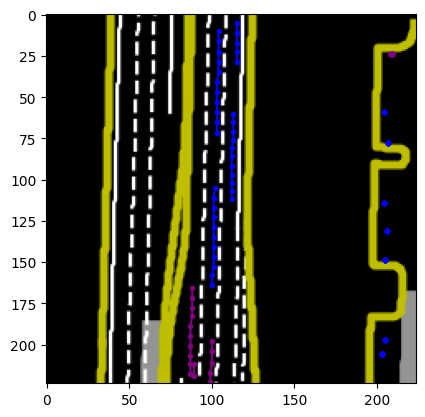

In [3]:
image_buffer = road_map[0].numpy() / 255.0
print(image_buffer.shape)

plt.imshow(image_buffer)
#plt.axis('off')

agent_cmap = ['blue', 'orange', 'yellow', 'purple']

trajectories = get_image_coordinates(agent_trajectories[0,:,:,:2])
for agent in range(trajectories.shape[0]):
    agent_trajectory = trajectories[agent, :, :]
    agent_type = agent_trajectories[0,agent,-1,-1].item()
    agent_type = 4 if math.isnan(agent_type) else int(agent_type)
    agent_color = agent_cmap[agent_type - 1]
    plt.plot(agent_trajectory[:, 0], agent_trajectory[:, 1], marker='o', markersize=3, color=agent_color)

plt.show()

/tmp/ipykernel_1010390/743861319.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


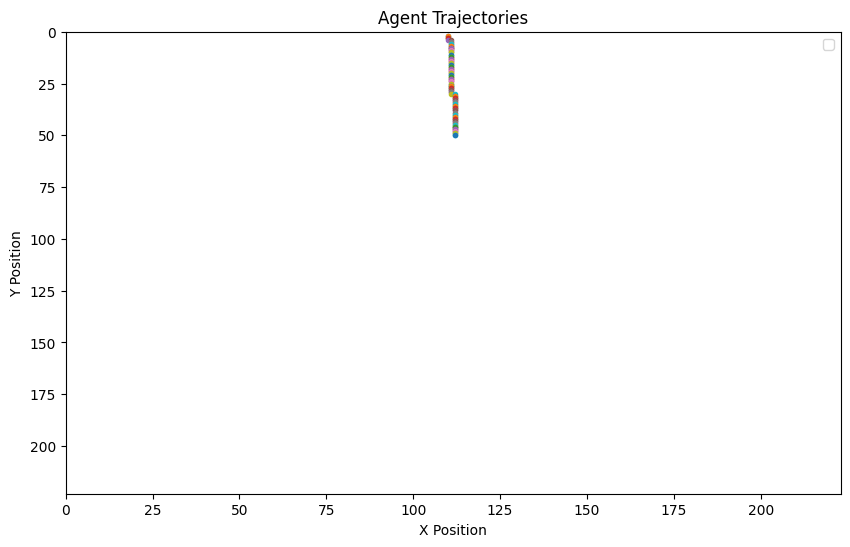

In [8]:
trajectories = agent_trajectories[:,:,:,:2]
batch, num_agents, seq_len, num_features = trajectories.shape
t = torch.linspace(0., 1., seq_len).to(agent_trajectories)
spline = NaturalCubicSpline(t, trajectories)

plt.figure(figsize=(10, 6))

SAMPLING_FREQUENCY = 100
for i in range(SAMPLING_FREQUENCY+1):
    t = i / SAMPLING_FREQUENCY
    positions = get_image_coordinates(spline.evaluate(t))
    plt.plot(positions[0,0,0].cpu().numpy(), positions[0,0,1].cpu().numpy(), 'o-', markersize=3)

plt.xlim(0, 223)
plt.ylim(0, 223)

plt.gca().invert_yaxis()

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Agent Trajectories')
plt.legend()
plt.show()

In [16]:
def group_indices(tensor):
    groups = defaultdict(list)
    tensor = torch.round(tensor * 10)
    for idx, val in enumerate(tensor):
        val = val.item() / 10
        groups[val].append(idx)
    return groups

positions = unobserved_positions[0] 
times = future_times[0] 
velocity = target_velocity[0]

groups = group_indices(times)
sorted_keys = sorted(groups.keys())

fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.imshow(image_buffer)
    time = list(sorted_keys)[frame]
    indices = groups[time]
    
    group_positions = get_image_coordinates(positions[indices])
    group_velocity = get_image_velocity(velocity[indices])

    ax.set_title(f"Future Flow (t = {time})")
    
    x_coords, y_coords = zip(*group_positions)
    ax.scatter(x_coords, y_coords, marker='o', s=5, color='blue')
    ax.quiver(x_coords, y_coords, group_velocity[:, 0], group_velocity[:, 1], 
              angles='xy', scale_units='xy', scale=1, color='red')

anim = FuncAnimation(fig, update, frames=len(groups), repeat=False)

plt.close(fig)

HTML(anim.to_jshtml())